# Group 2 Optical Character Recognition Project Project - Group 2
## Summary
This project is to explore creating a character recognition system utilizing a convolutional neural network
## Completed By:
Aidan MacNichol – 30094369

Bailey Collison – 30133909

David Pozniak – 00324580

Yael Gonzalez - 30247278

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [ ]:
# Function to compute dataset statistics (same as mnist example)
def get_dataset_stats(data_loader):
    mean = 0.
    std = 0.
    nb_samples = 0.
    for data in data_loader:
        images = data[0]
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        nb_samples += batch_samples
    mean /= nb_samples
    std /= nb_samples
    return mean, std

# functions to show an image (also same as mnist example)
def imshow(img,stats):
    # when unnormalizing, I had to add extra channels for RGB
    img = img * stats[1].view(-1, 1, 1) + stats[0].view(-1, 1, 1)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [10]:
batch_size = 256

initial_transform = transforms.Compose([
    transforms.Resize((28, 28)),  # I was getting an error if I didn't resize
    transforms.ToTensor()
])

train_folder = "./data/training_data"
test_folder = "./data/testing_data"

train_dataset_initial = torchvision.datasets.ImageFolder(root=train_folder, transform=initial_transform)

train_set_size = int(0.8 * len(train_dataset_initial))
val_set_size = len(train_dataset_initial) - train_set_size

# Split the development set into train and validation
train_subset, val_subset = torch.utils.data.random_split(train_dataset_initial, [train_set_size, val_set_size],
                                                           generator=torch.Generator().manual_seed(42))

# Get the data loader for the train set
train_loader_initial = torch.utils.data.DataLoader(train_subset, batch_size=batch_size,
                                                   shuffle=True, num_workers=2)

# Comopute the statistics of the train set
stats = get_dataset_stats(train_loader_initial)
print("Train stats:", stats)
# Pre-processing transforms
transform = transforms.Compose(
    [transforms.Resize((28, 28)),
    transforms.ToTensor(),
     transforms.Normalize((stats[0]), (stats[1]))])

# Reload the dataset with the new transform
train_dataset = torchvision.datasets.ImageFolder(root=train_folder, transform=transform)
train_set, val_set = torch.utils.data.random_split(train_dataset, [train_set_size, val_set_size], generator=torch.Generator().manual_seed(42))

# Load test dataset with same transform
test_dataset = torchvision.datasets.ImageFolder(root=test_folder, transform=transform)

# data loaders for training, validation, and test sets
trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# get classes from folder names
classes = train_dataset.classes
print("Classes:", classes)

Train stats: (tensor([0.5888, 0.5888, 0.5888]), tensor([0.2706, 0.2706, 0.2706]))
Classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


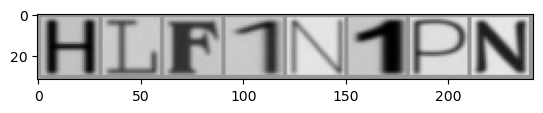

H     L     F     1     N     1     P     N    


In [ ]:
# get some random training images and print them
dataiter = iter(trainloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:8]), stats)
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(8)))

In [ ]:
class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()
        # 3 input channels because of RGB, 32 output channels, 3x3 kernel
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # Convolutional layer + ReLU + MaxPooling
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        # max pooling
        x = F.max_pool2d(x, 2)
        # Flatten the tensor into a 1D vector
        x = x.view(-1, 64 * 12 * 12)
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

num_classes = len(train_dataset.classes)
print("Number of classes: ", num_classes)

net = Net(num_classes)
net.to(device)

Number of classes:  36


Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=36, bias=True)
)

In [16]:
criterion = nn.CrossEntropyLoss() # Loss function
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) # Optimizer used for training

In [ ]:
nepochs = 20
PATH = './cifar_net.pth'

best_loss = 1e+20
for epoch in range(nepochs):
    # Training Loop
    train_loss = 0.0
    # set to training mode
    net.train()
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(f'{epoch + 1},  train loss: {train_loss / i:.3f},', end = ' ')
    # set to evaluation mode
    net.eval()
    val_loss = 0
    with torch.no_grad():
        for i, data in enumerate(valloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
        print(f'val loss: {val_loss / i:.3f}')
        
        # Save best model
        if val_loss < best_loss:
            print("Saving model")
            torch.save(net.state_dict(), PATH)
        
print('Finished Training')

1,  train loss: 3.511, val loss: 3.388
Saving model
2,  train loss: 2.023, val loss: 0.877
Saving model
3,  train loss: 0.627, val loss: 0.701
Saving model
4,  train loss: 0.495, val loss: 0.584
Saving model
5,  train loss: 0.430, val loss: 0.447
Saving model
6,  train loss: 0.386, val loss: 0.430
Saving model
7,  train loss: 0.347, val loss: 0.382
Saving model
8,  train loss: 0.326, val loss: 0.393
Saving model
9,  train loss: 0.314, val loss: 0.349
Saving model
10,  train loss: 0.295, val loss: 0.329
Saving model
11,  train loss: 0.278, val loss: 0.313
Saving model
12,  train loss: 0.252, val loss: 0.297
Saving model
13,  train loss: 0.241, val loss: 0.292
Saving model
14,  train loss: 0.231, val loss: 0.284
Saving model
15,  train loss: 0.233, val loss: 0.298
Saving model
16,  train loss: 0.222, val loss: 0.271
Saving model
17,  train loss: 0.201, val loss: 0.268
Saving model
18,  train loss: 0.196, val loss: 0.239
Saving model
19,  train loss: 0.182, val loss: 0.237
Saving model
20

In [19]:
# Load the best model to be used in the test set
net = Net(num_classes)
net.load_state_dict(torch.load(PATH))

C:\Users\Baile\AppData\Local\Temp\ipykernel_35252\2488931302.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(PATH))


<All keys matched successfully>

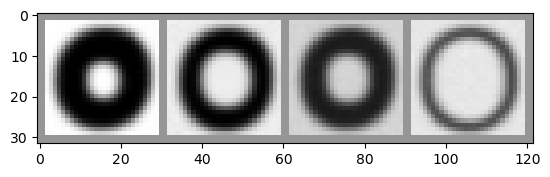

GroundTruth:  0     0     0     0    


In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)
# print images
imshow(torchvision.utils.make_grid(images[:4]), stats)
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
outputs = net(images)

In [21]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  0     0     0     O    


In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total} %')

Accuracy of the network on the 10000 test images: 98.11507936507937 %


In [ ]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: 0     is 46.4 %
Accuracy for class: 1     is 100.0 %
Accuracy for class: 2     is 100.0 %
Accuracy for class: 3     is 100.0 %
Accuracy for class: 4     is 100.0 %
Accuracy for class: 5     is 100.0 %
Accuracy for class: 6     is 96.4 %
Accuracy for class: 7     is 100.0 %
Accuracy for class: 8     is 100.0 %
Accuracy for class: 9     is 100.0 %
Accuracy for class: A     is 100.0 %
Accuracy for class: B     is 100.0 %
Accuracy for class: C     is 100.0 %
Accuracy for class: D     is 100.0 %
Accuracy for class: E     is 96.4 %
Accuracy for class: F     is 100.0 %
Accuracy for class: G     is 100.0 %
Accuracy for class: H     is 100.0 %
Accuracy for class: I     is 100.0 %
Accuracy for class: J     is 100.0 %
Accuracy for class: K     is 100.0 %
Accuracy for class: L     is 100.0 %
Accuracy for class: M     is 100.0 %
Accuracy for class: N     is 100.0 %
Accuracy for class: O     is 92.9 %
Accuracy for class: P     is 100.0 %
Accuracy for class: Q     is 100.0 %
Accur